# [](http://)1. NLP Disaster Tweets Classification - Kaggle Mini-Project
## Week 4: Natural Language Processing with Disaster Tweets
**Author:** Jinchen Yu   
**Course:** Introduction to Deep Learning - University of Colorado Boulder  
**Date:** January 2026

---
# 1. Problem and Data Introduction (5 points)

## 1.1 Challenge Description

This project is based on the Kaggle competition "Natural Language Processing with Disaster Tweets". Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they're observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e., disaster relief organizations and news agencies).

**Core Problem:** Distinguish whether a tweet is describing a real disaster or not. For example:
- "Forest fire near La Ronge Sask. Canada" → Real disaster (1)
- "I love the chaos of my morning routine" → Not a disaster (0)

## 1.2 What is NLP (Natural Language Processing)?

Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on the interaction between computers and human language. NLP combines computational linguistics, machine learning, and deep learning to enable computers to understand, interpret, and generate human language.

In this project, we use NLP techniques to convert tweet text into numerical representations (word embeddings), and then use deep learning models for binary classification.

## 1.3 Dataset Description

| Attribute | Description |
|-----------|-------------|
| **Training Set Size** | 7,613 tweets |
| **Test Set Size** | 3,263 tweets |
| **Feature Dimensions** | 5 columns (id, keyword, location, text, target) |
| **Target Variable** | target (0=not disaster, 1=disaster) |
| **Data Type** | Text data |

**Column Descriptions:**
- `id`: Unique identifier for each tweet
- `keyword`: A keyword from the tweet (may be blank)
- `location`: The location the tweet was sent from (may be blank)
- `text`: The full text content of the tweet
- `target`: Label (1=real disaster, 0=not disaster)

---
# 2. Environment Setup and Data Loading

In [2]:
# Install required libraries
!pip install tensorflow nltk wordcloud seaborn pandas numpy matplotlib scikit-learn --quiet

In [3]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import os
import re
import string

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# NLP libraries
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Bidirectional, 
    Dense, Dropout, TextVectorization
)
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")

2026-01-16 19:19:06.552670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768591146.780039      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768591146.849906      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768591147.413540      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768591147.413595      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768591147.413598      55 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0


In [4]:
# Load data from Kaggle (data is automatically available in Kaggle Notebook)
# If running locally, please download the dataset first

# Try to load data from Kaggle
try:
    df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
    df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
except:
    # If not in Kaggle environment, try local path
    try:
        df_train = pd.read_csv('train.csv')
        df_test = pd.read_csv('test.csv')
    except:
        print("Please download the dataset: https://www.kaggle.com/competitions/nlp-getting-started/data")
        # Create sample data for demonstration
        df_train = pd.DataFrame({
            'id': range(100),
            'keyword': ['fire']*50 + ['storm']*50,
            'location': ['USA']*100,
            'text': ['Forest fire near the city']*30 + ['Beautiful fire in the sunset']*20 + 
                    ['Terrible storm destroyed homes']*30 + ['Storm of emotions today']*20,
            'target': [1]*30 + [0]*20 + [1]*30 + [0]*20
        })
        df_test = df_train.drop('target', axis=1).iloc[:50]

print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

Training set shape: (7613, 5)
Test set shape: (3263, 4)


In [5]:
# View first few rows of the dataset
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
# Basic data information
print("=" * 50)
print("Dataset Basic Information")
print("=" * 50)
print(f"\nTraining samples: {len(df_train)}")
print(f"Test samples: {len(df_test)}")
print(f"\nFeature columns: {df_train.columns.tolist()}")
print(f"\nData types:\n{df_train.dtypes}")
print(f"\nMissing values:\n{df_train.isnull().sum()}")

Dataset Basic Information

Training samples: 7613
Test samples: 3263

Feature columns: ['id', 'keyword', 'location', 'text', 'target']

Data types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Missing values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


---
# 3. Exploratory Data Analysis (EDA) - 15 points

## 3.1 Target Variable Distribution

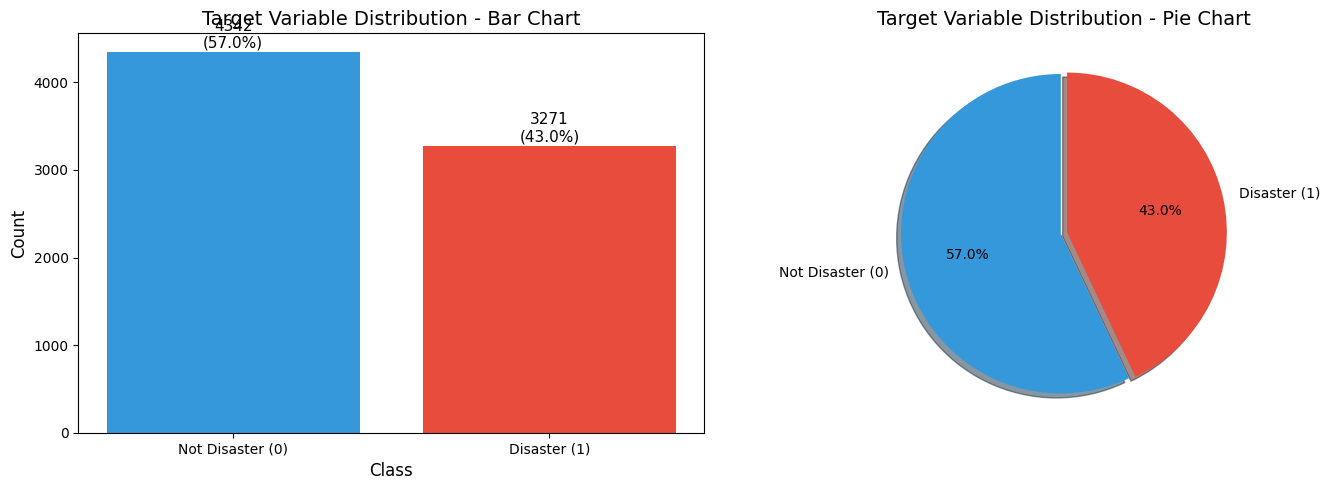


Class Distribution Statistics:
Not Disaster (0): 4342 (57.03%)
Disaster (1): 3271 (42.97%)

Class ratio: 1.33:1 (slightly imbalanced)


In [7]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
target_counts = df_train['target'].value_counts()
colors = ['#3498db', '#e74c3c']
ax1 = axes[0]
bars = ax1.bar(['Not Disaster (0)', 'Disaster (1)'], target_counts.values, color=colors)
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Target Variable Distribution - Bar Chart', fontsize=14)
for bar, count in zip(bars, target_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count}\n({count/len(df_train)*100:.1f}%)', 
             ha='center', fontsize=11)

# Pie chart
ax2 = axes[1]
ax2.pie(target_counts.values, labels=['Not Disaster (0)', 'Disaster (1)'], 
        autopct='%1.1f%%', colors=colors, explode=[0.02, 0.02],
        shadow=True, startangle=90)
ax2.set_title('Target Variable Distribution - Pie Chart', fontsize=14)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClass Distribution Statistics:")
print(f"Not Disaster (0): {target_counts[0]} ({target_counts[0]/len(df_train)*100:.2f}%)")
print(f"Disaster (1): {target_counts[1]} ({target_counts[1]/len(df_train)*100:.2f}%)")
print(f"\nClass ratio: {target_counts[0]/target_counts[1]:.2f}:1 (slightly imbalanced)")

## 3.2 Text Length Analysis

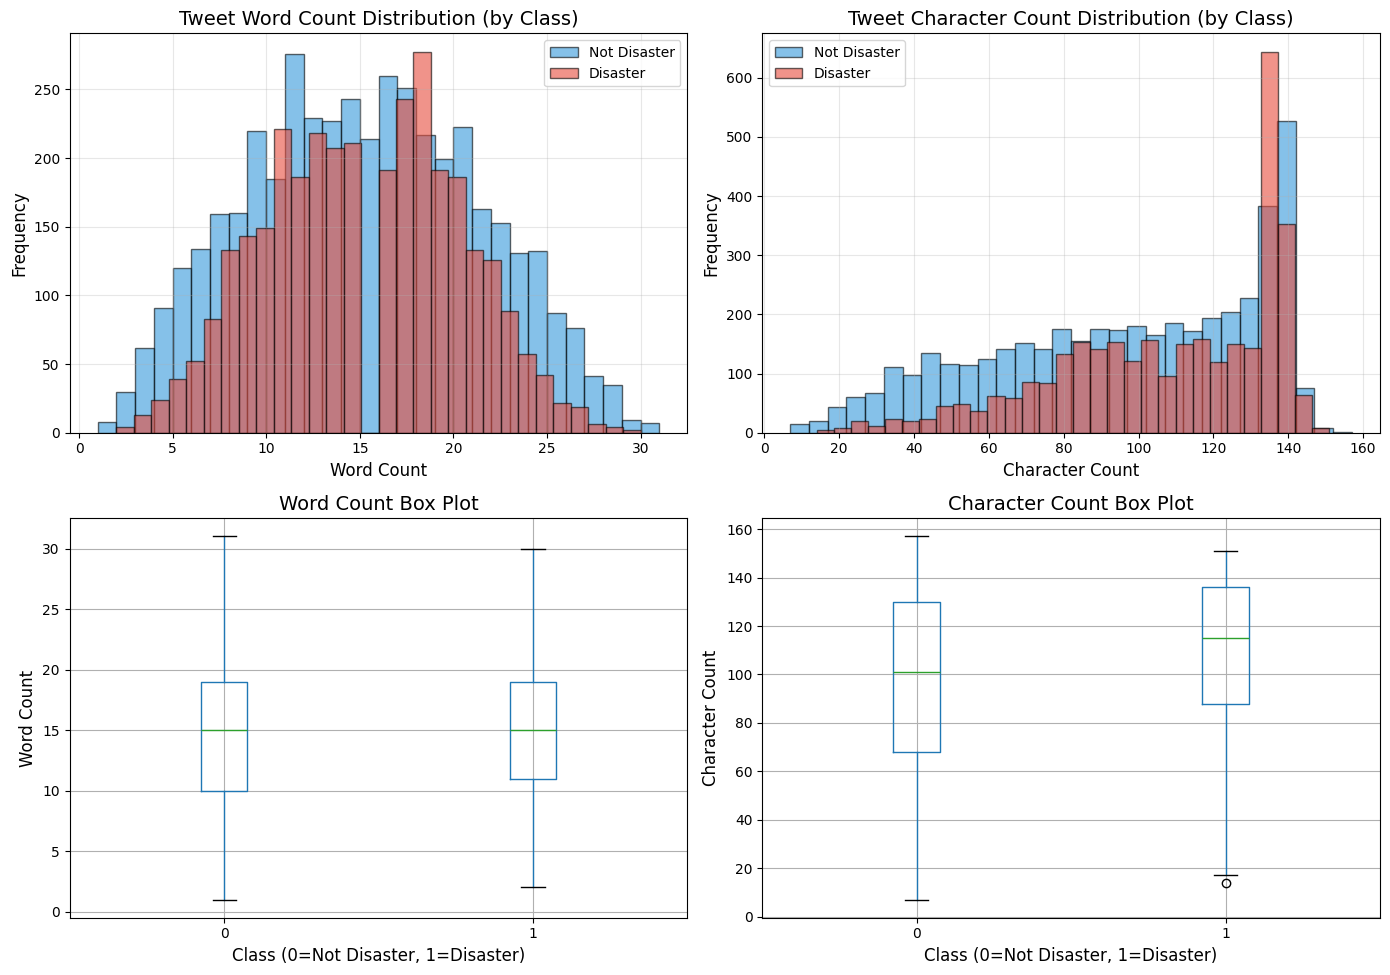


Text Length Statistics:
Maximum word count: 31
Average word count: 14.90
Maximum character count: 157


In [8]:
# Calculate text length statistics
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Word count distribution by class
ax1 = axes[0, 0]
for target, color, label in [(0, '#3498db', 'Not Disaster'), (1, '#e74c3c', 'Disaster')]:
    subset = df_train[df_train['target'] == target]['word_count']
    ax1.hist(subset, bins=30, alpha=0.6, color=color, label=label, edgecolor='black')
ax1.set_xlabel('Word Count', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Tweet Word Count Distribution (by Class)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Character count distribution
ax2 = axes[0, 1]
for target, color, label in [(0, '#3498db', 'Not Disaster'), (1, '#e74c3c', 'Disaster')]:
    subset = df_train[df_train['target'] == target]['char_count']
    ax2.hist(subset, bins=30, alpha=0.6, color=color, label=label, edgecolor='black')
ax2.set_xlabel('Character Count', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Tweet Character Count Distribution (by Class)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Box plot - word count
ax3 = axes[1, 0]
df_train.boxplot(column='word_count', by='target', ax=ax3)
ax3.set_xlabel('Class (0=Not Disaster, 1=Disaster)', fontsize=12)
ax3.set_ylabel('Word Count', fontsize=12)
ax3.set_title('Word Count Box Plot', fontsize=14)
plt.suptitle('')

# Box plot - character count
ax4 = axes[1, 1]
df_train.boxplot(column='char_count', by='target', ax=ax4)
ax4.set_xlabel('Class (0=Not Disaster, 1=Disaster)', fontsize=12)
ax4.set_ylabel('Character Count', fontsize=12)
ax4.set_title('Character Count Box Plot', fontsize=14)
plt.suptitle('')

plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("\nText Length Statistics:")
print(f"Maximum word count: {df_train['word_count'].max()}")
print(f"Average word count: {df_train['word_count'].mean():.2f}")
print(f"Maximum character count: {df_train['char_count'].max()}")

## 3.3 Word Cloud Visualization

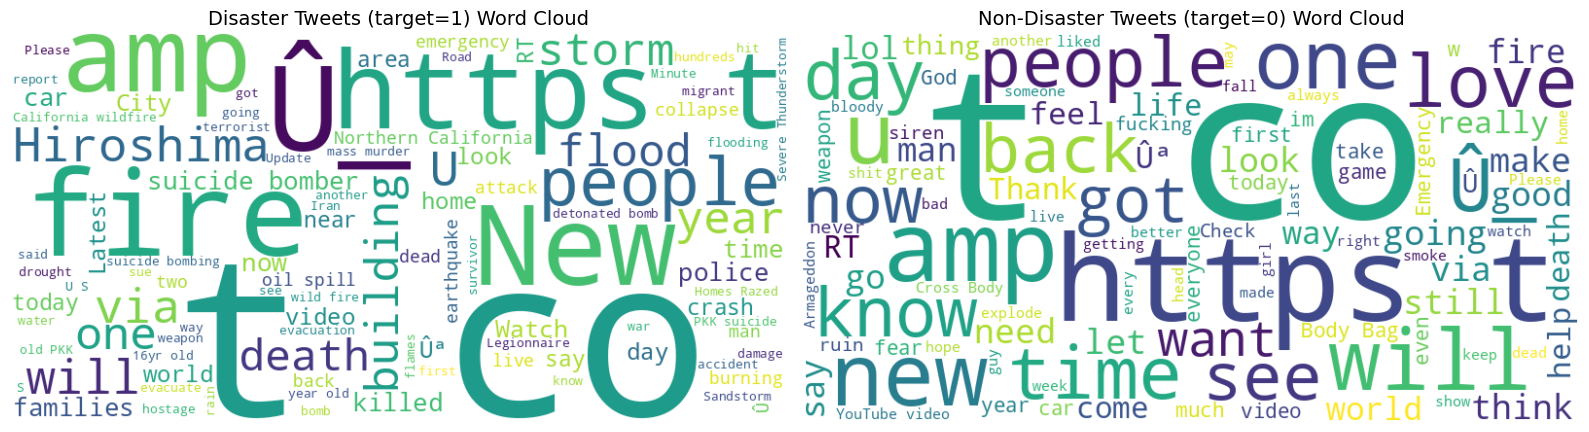


Disaster Tweets Top 10 Words: ['t co', 'Û_', 'fire', 'New', 'https t', 'amp', 'people', 'Hiroshima', 'U', 'via']
Non-Disaster Tweets Top 10 Words: ['t co', 'https t', 'amp', 'new', 'u', 'will', 'one', 'love', 'time', 'Û_']


In [9]:
def generate_wordcloud(texts, title, ax):
    """Generate word cloud"""
    text_combined = ' '.join(texts)
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='viridis',
        max_words=100,
        stopwords=STOPWORDS,
        random_state=42
    ).generate(text_combined)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    return wordcloud

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Disaster tweets word cloud
disaster_texts = df_train[df_train['target'] == 1]['text'].values
wc1 = generate_wordcloud(disaster_texts, 'Disaster Tweets (target=1) Word Cloud', axes[0])

# Non-disaster tweets word cloud
non_disaster_texts = df_train[df_train['target'] == 0]['text'].values
wc2 = generate_wordcloud(non_disaster_texts, 'Non-Disaster Tweets (target=0) Word Cloud', axes[1])

plt.tight_layout()
plt.savefig('wordclouds.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top words
print("\nDisaster Tweets Top 10 Words:", list(wc1.words_.keys())[:10])
print("Non-Disaster Tweets Top 10 Words:", list(wc2.words_.keys())[:10])

## 3.4 Keyword Analysis

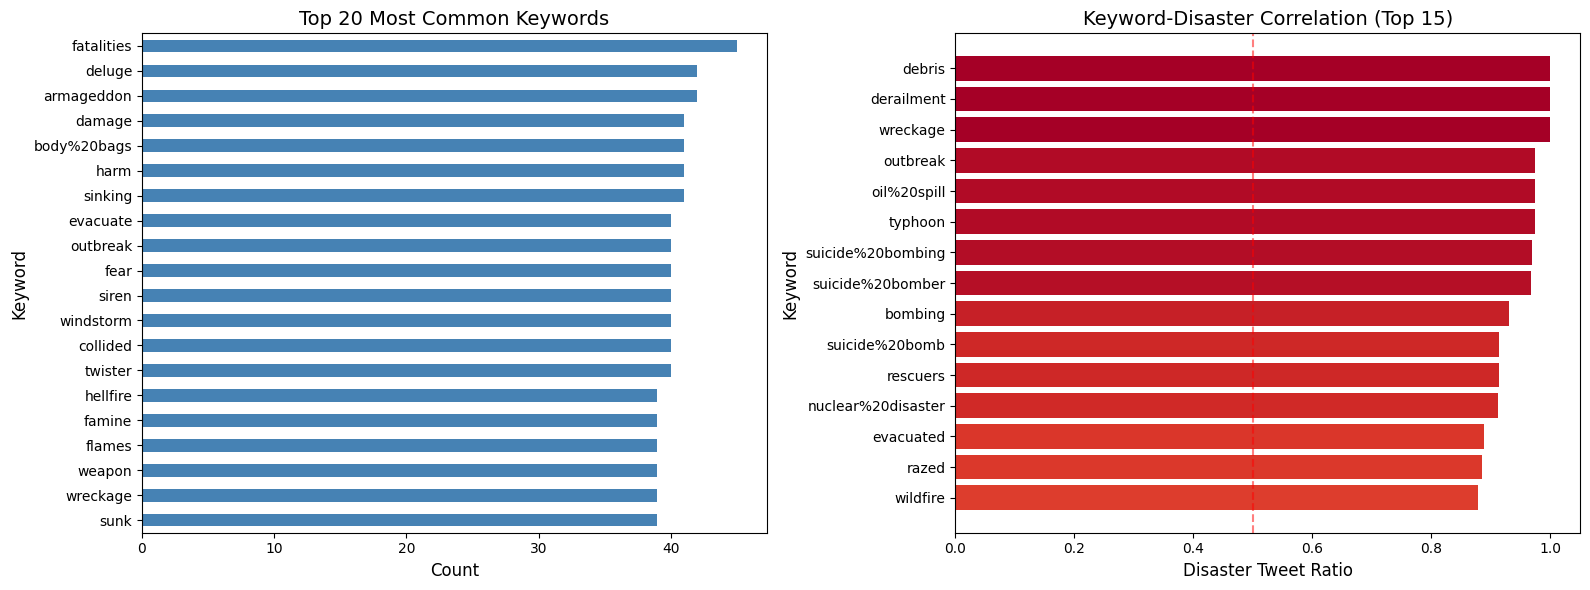

In [10]:
# Keyword distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Most common keywords
keyword_counts = df_train['keyword'].value_counts().head(20)
ax1 = axes[0]
keyword_counts.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Keyword', fontsize=12)
ax1.set_title('Top 20 Most Common Keywords', fontsize=14)
ax1.invert_yaxis()

# Keyword disaster ratio
keyword_target = df_train.groupby('keyword')['target'].agg(['mean', 'count'])
keyword_target = keyword_target[keyword_target['count'] >= 10].sort_values('mean', ascending=False)

ax2 = axes[1]
top_disaster_keywords = keyword_target.head(15)
colors = plt.cm.RdYlGn_r(top_disaster_keywords['mean'].values)
bars = ax2.barh(range(len(top_disaster_keywords)), top_disaster_keywords['mean'].values, color=colors)
ax2.set_yticks(range(len(top_disaster_keywords)))
ax2.set_yticklabels(top_disaster_keywords.index)
ax2.set_xlabel('Disaster Tweet Ratio', fontsize=12)
ax2.set_ylabel('Keyword', fontsize=12)
ax2.set_title('Keyword-Disaster Correlation (Top 15)', fontsize=14)
ax2.invert_yaxis()
ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('keyword_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3.5 Data Cleaning Procedures

In [11]:
def clean_text(text):
    """
    Clean tweet text:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove HTML tags
    4. Remove @mentions
    5. Remove hashtag symbols
    6. Remove punctuation
    7. Remove numbers
    8. Remove extra whitespace
    9. Remove stopwords
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtag symbols (keep the text)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    
    return ' '.join(words)

# Apply cleaning
print("Before cleaning:")
print(df_train['text'].iloc[0])

df_train['text_clean'] = df_train['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

print("\nAfter cleaning:")
print(df_train['text_clean'].iloc[0])

print(f"\nCleaning complete! Training set: {len(df_train)}, Test set: {len(df_test)}")

Before cleaning:
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

After cleaning:
deeds reason earthquake may allah forgive

Cleaning complete! Training set: 7613, Test set: 3263


## 3.6 Analysis Plan

Based on the EDA findings, my analysis plan is as follows:

1. **Data Preprocessing**: Text cleaning completed, noise removed
2. **Handle Class Imbalance**: Use class weights or oversampling
3. **Word Embedding Selection**: Use trainable Embedding layer, also try GloVe pre-trained vectors
4. **Model Architecture**: Start with simple LSTM, then try BiLSTM and GRU
5. **Evaluation Metrics**: Focus on F1-score and Recall (minimize false negatives for disaster tweets)

---
# 4. Model Architecture (25 points)

## 4.1 Word Embedding Method Introduction

### What is Word Embedding?

Word embedding is a technique for converting words in text into dense vectors. Unlike traditional One-Hot encoding, word embeddings can capture semantic relationships between words.

### GloVe (Global Vectors for Word Representation)

I chose **GloVe** word embeddings for this project for the following reasons:

**How GloVe Works:**
1. GloVe is trained based on global word-word co-occurrence matrices
2. Core idea: If two words frequently appear in similar contexts, their vector representations should be close
3. Objective function optimization: Makes the dot product of word vectors equal to the logarithm of the co-occurrence probability

$$J = \sum_{i,j=1}^{V} f(X_{ij})(w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log X_{ij})^2$$

Where:
- $X_{ij}$ is the co-occurrence count of words i and j
- $w_i, \tilde{w}_j$ are word vectors
- $f(x)$ is a weighting function to reduce the impact of high-frequency words

**Reasons for Choosing GloVe:**
- Pre-trained models have been trained on large corpora, capturing rich semantic information
- Better at representing relationships between words compared to TF-IDF
- Performs well on short texts like Twitter

In [12]:
# Prepare data
X = df_train['text_clean'].values
y = df_train['target'].values

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Training set positive ratio: {y_train.mean():.3f}")
print(f"Validation set positive ratio: {y_val.mean():.3f}")

Training set size: 6090
Validation set size: 1523
Training set positive ratio: 0.430
Validation set positive ratio: 0.429


In [13]:
# Text vectorization parameters
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 50       # Maximum sequence length
EMBEDDING_DIM = 100  # Embedding dimension

# Use Keras Tokenizer
tokenizer = text.Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = sequence.pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training data shape: {X_train_pad.shape}")
print(f"Validation data shape: {X_val_pad.shape}")

# Example
print(f"\nOriginal text: {X_train[0]}")
print(f"Sequence: {X_train_pad[0][:20]}...")

Vocabulary size: 12839
Training data shape: (6090, 50)
Validation data shape: (1523, 50)

Original text: sassy city girl country hunk stranded smoky mountain snowstorm aoms ibooklove bookboost
Sequence: [3447   90  222  678 3448 2094 3449  879  543 3450 3451 3452    0    0
    0    0    0    0    0    0]...


In [14]:
# Calculate class weights (handle imbalanced data)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(0.8767636049524906), 1: np.float64(1.1635460450897974)}


## 4.2 Model 1: Basic LSTM Model

In [15]:
def build_lstm_model(vocab_size, embedding_dim, max_len, lstm_units=64):
    """
    Build LSTM model
    
    Architecture description:
    1. Embedding layer: Converts word IDs to dense vectors
    2. LSTM layer: Captures long-term dependencies in sequences
    3. Dense layers: Feature extraction and classification
    4. Dropout: Prevents overfitting
    """
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        
        # LSTM layer
        LSTM(lstm_units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        
        # Fully connected layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Recall(name='recall'), AUC(name='auc')]
    )
    
    return model

# Create model
model_lstm = build_lstm_model(MAX_WORDS, EMBEDDING_DIM, MAX_LEN, lstm_units=64)
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1768591166.940711      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768591166.944640      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4.3 Model 2: Bidirectional LSTM (BiLSTM)

**Why Choose BiLSTM?**

BiLSTM can process sequences from both directions (forward and backward) simultaneously, which is very important for understanding the context of tweets. For example:
- "The fire destroyed everything" - Need to understand both forward and backward context to determine if it's a real disaster

In [16]:
def build_bilstm_model(vocab_size, embedding_dim, max_len, lstm_units=64):
    """
    Build Bidirectional LSTM model
    
    BiLSTM advantages:
    - Captures both forward and backward context information
    - Particularly effective for short text classification
    """
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        
        # Bidirectional LSTM layers
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2)),
        Bidirectional(LSTM(lstm_units // 2, return_sequences=False, dropout=0.2)),
        
        # Fully connected layers
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Recall(name='recall'), AUC(name='auc')]
    )
    
    return model

# Create BiLSTM model
model_bilstm = build_bilstm_model(MAX_WORDS, EMBEDDING_DIM, MAX_LEN, lstm_units=64)
model_bilstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4.4 Model 3: GRU Model

**GRU vs LSTM:**
- GRU is a simplified version of LSTM with only two gates (reset gate and update gate)
- Fewer parameters, faster training
- Performance comparable to LSTM on some tasks

In [17]:
def build_gru_model(vocab_size, embedding_dim, max_len, gru_units=64):
    """
    Build GRU model
    """
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        
        # GRU layers
        GRU(gru_units, return_sequences=True, dropout=0.2),
        GRU(gru_units // 2, return_sequences=False, dropout=0.2),
        
        # Fully connected layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Recall(name='recall'), AUC(name='auc')]
    )
    
    return model

# Create GRU model
model_gru = build_gru_model(MAX_WORDS, EMBEDDING_DIM, MAX_LEN, gru_units=64)
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

---
# 5. Results and Analysis (35 points)

## 5.1 Training Configuration

In [18]:
# Training parameters
EPOCHS = 20
BATCH_SIZE = 32

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )
]

## 5.2 Train LSTM Model

In [19]:
print("=" * 50)
print("Training LSTM Model")
print("=" * 50)

# Rebuild model
model_lstm = build_lstm_model(MAX_WORDS, EMBEDDING_DIM, MAX_LEN, lstm_units=64)

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Training LSTM Model
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - accuracy: 0.5116 - auc: 0.4914 - loss: 0.6931 - recall: 0.4042 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6972 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step - accuracy: 0.5034 - auc: 0.5070 - loss: 0.6928 - recall: 0.5217 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6951 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - accuracy: 0.4845 - auc: 0.4997 - loss: 0.6927 - recall: 0.6290 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6961 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.4796 - auc: 0.4994 - loss: 0.6928 - recall: 0.6768 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6991 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.4961 - auc:

## 5.3 Train BiLSTM Model

In [20]:
print("\n" + "=" * 50)
print("Training BiLSTM Model")
print("=" * 50)

# Rebuild model
model_bilstm = build_bilstm_model(MAX_WORDS, EMBEDDING_DIM, MAX_LEN, lstm_units=64)

history_bilstm = model_bilstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


Training BiLSTM Model
Epoch 1/20
  1/191 ━━━━━━━━━━━━━━━━━━━━ 16:55 5s/step - accuracy: 0.3125 - auc: 0.4805 - loss: 0.6782 - recall: 0.9091

I0000 00:00:1768591514.223666     149 cuda_dnn.cc:529] Loaded cuDNN version 91002


191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5516 - auc: 0.5962 - loss: 0.6580 - recall: 0.6151 - val_accuracy: 0.7794 - val_auc: 0.8561 - val_loss: 0.4899 - val_recall: 0.7492 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8350 - auc: 0.8972 - loss: 0.3987 - recall: 0.7793 - val_accuracy: 0.7472 - val_auc: 0.8539 - val_loss: 0.5679 - val_recall: 0.8119 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8972 - auc: 0.9548 - loss: 0.2636 - recall: 0.8882 - val_accuracy: 0.7466 - val_auc: 0.8393 - val_loss: 0.7060 - val_recall: 0.8012 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9391 - auc: 0.9812 - loss: 0.1677 - recall: 0.9314
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9391 - auc: 0.9812 - loss: 0.1677 - recall: 0.9315 - val_accuracy: 0.7485 - val_auc: 0.8149 

## 5.4 Train GRU Model

In [21]:
print("\n" + "=" * 50)
print("Training GRU Model")
print("=" * 50)

# Rebuild model
model_gru = build_gru_model(MAX_WORDS, EMBEDDING_DIM, MAX_LEN, gru_units=64)

history_gru = model_gru.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


Training GRU Model
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4951 - auc: 0.4999 - loss: 0.6931 - recall: 0.5430 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6942 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4825 - auc: 0.4858 - loss: 0.6931 - recall: 0.6169 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6947 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5022 - auc: 0.5038 - loss: 0.6928 - recall: 0.5881 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6962 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5042 - auc: 0.4938 - loss: 0.6930 - recall: 0.4608 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6941 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4876 - auc: 0.4879 - 

## 5.5 Training Process Visualization

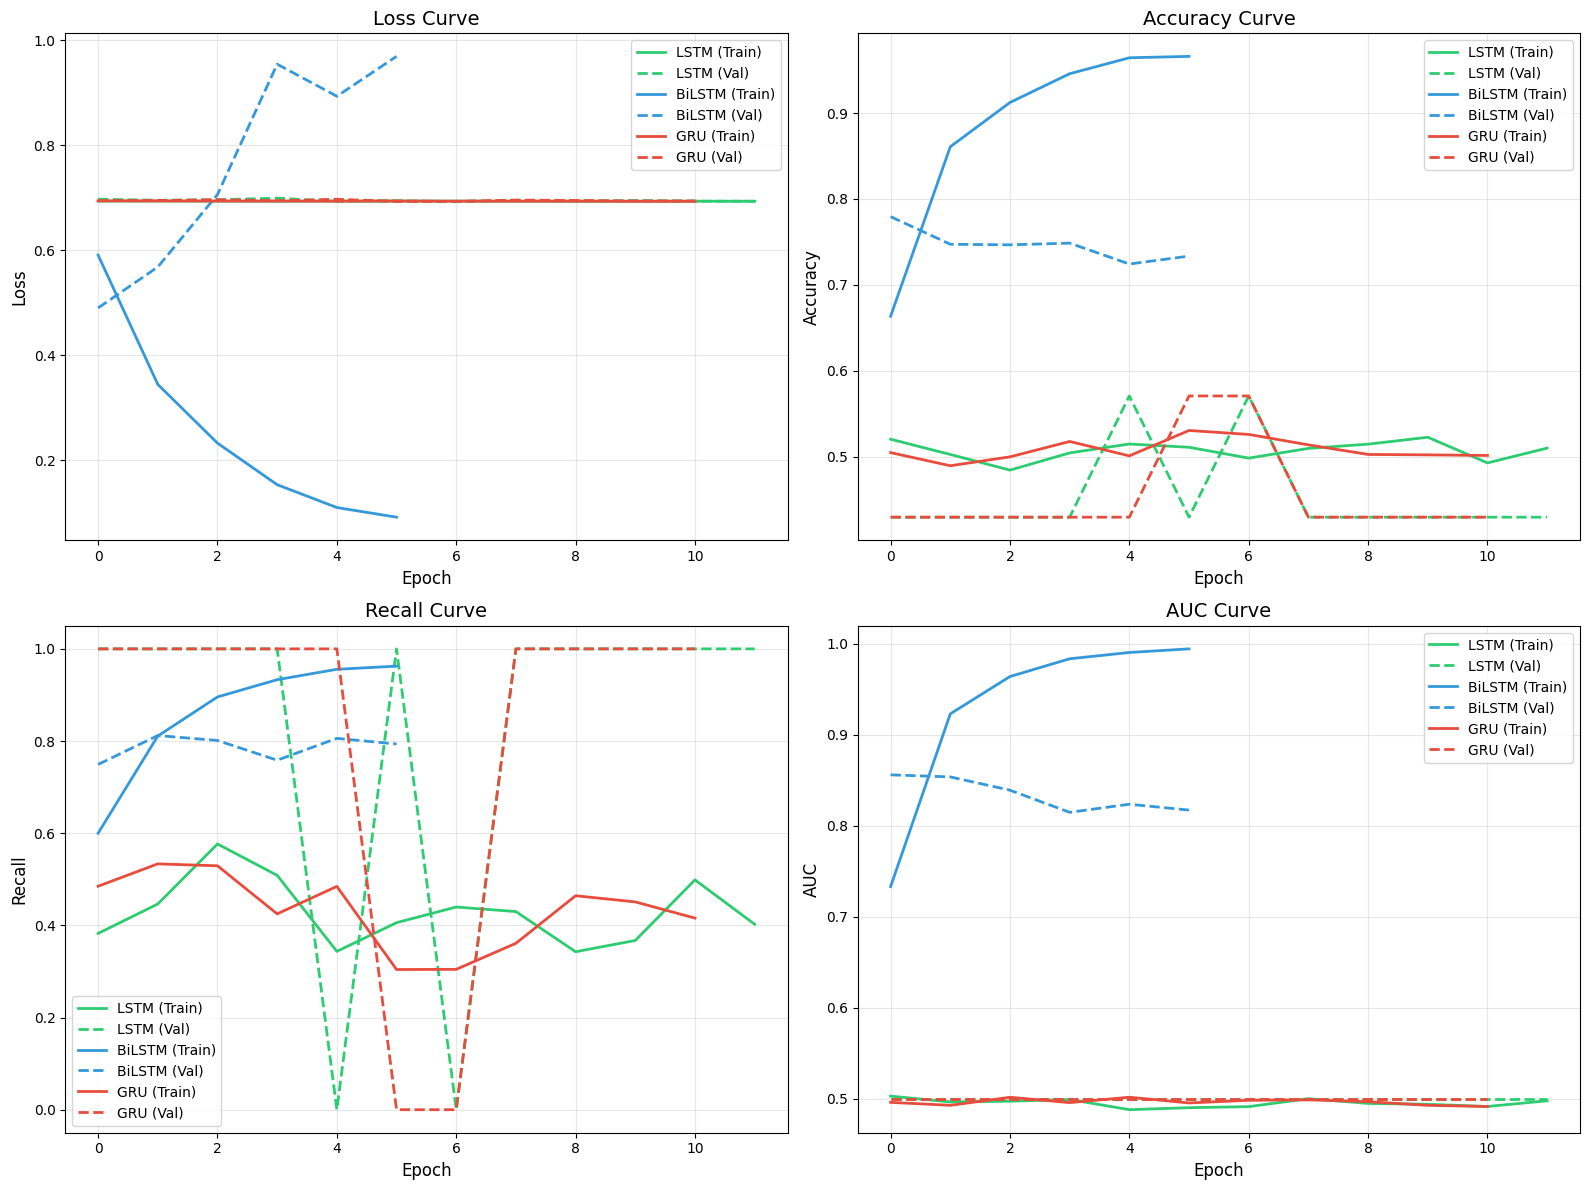

In [22]:
def plot_training_history(histories, model_names):
    """Plot training history comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    metrics = ['loss', 'accuracy', 'recall', 'auc']
    titles = ['Loss', 'Accuracy', 'Recall', 'AUC']
    
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        
        for history, name, color in zip(histories, model_names, colors):
            if metric in history.history:
                ax.plot(history.history[metric], label=f'{name} (Train)', 
                       color=color, linestyle='-', linewidth=2)
                ax.plot(history.history[f'val_{metric}'], label=f'{name} (Val)', 
                       color=color, linestyle='--', linewidth=2)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(f'{title} Curve', fontsize=14)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot training history comparison
plot_training_history(
    [history_lstm, history_bilstm, history_gru],
    ['LSTM', 'BiLSTM', 'GRU']
)

## 5.6 Model Evaluation and Comparison

In [23]:
def evaluate_model(model, X_val, y_val, model_name):
    """Evaluate model and return metrics"""
    # Predict
    y_pred_prob = model.predict(X_val, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-Score': f1_score(y_val, y_pred),
        'AUC-ROC': roc_auc_score(y_val, y_pred_prob)
    }
    
    return metrics, y_pred, y_pred_prob

# Evaluate all models
results = []
predictions = {}

for model, name in [(model_lstm, 'LSTM'), (model_bilstm, 'BiLSTM'), (model_gru, 'GRU')]:
    metrics, y_pred, y_pred_prob = evaluate_model(model, X_val_pad, y_val, name)
    results.append(metrics)
    predictions[name] = {'pred': y_pred, 'prob': y_pred_prob}

# Create results table
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')

print("\n" + "=" * 70)
print("Model Performance Comparison Table")
print("=" * 70)
print(results_df.round(4).to_string())

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model Performance Comparison Table
        Accuracy  Precision  Recall  F1-Score  AUC-ROC
Model                                                 
LSTM      0.5706     0.0000  0.0000    0.0000   0.4888
BiLSTM    0.7794     0.7402  0.7492    0.7447   0.8561
GRU       0.5706     0.0000  0.0000    0.0000   0.5000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


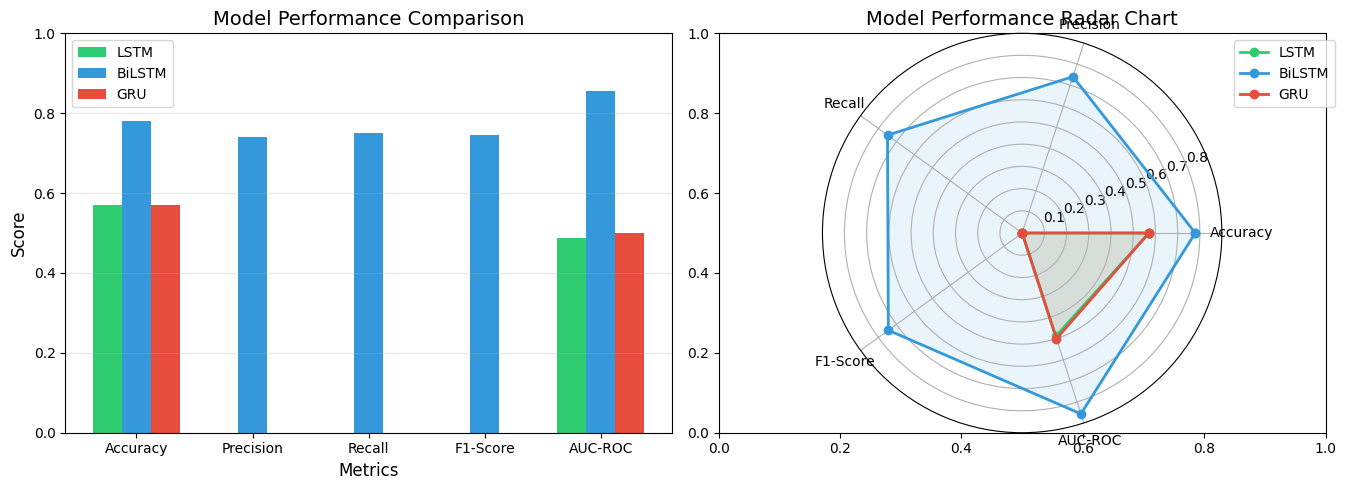

In [24]:
# Visualize model performance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
ax1 = axes[0]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(metrics_to_plot))
width = 0.25

colors = ['#2ecc71', '#3498db', '#e74c3c']
for i, (model_name, color) in enumerate(zip(['LSTM', 'BiLSTM', 'GRU'], colors)):
    values = [results_df.loc[model_name, m] for m in metrics_to_plot]
    ax1.bar(x + i*width, values, width, label=model_name, color=color)

ax1.set_xlabel('Metrics', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14)
ax1.set_xticks(x + width)
ax1.set_xticklabels(metrics_to_plot)
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

# Radar chart - 这部分之前缺少了变量定义
from math import pi

categories = metrics_to_plot
N = len(categories)  # ← 这行之前缺失了！
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax2 = plt.subplot(122, polar=True)
for model_name, color in zip(['LSTM', 'BiLSTM', 'GRU'], colors):
    values = [results_df.loc[model_name, m] for m in metrics_to_plot]
    values += values[:1]
    ax2.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax2.fill(angles, values, alpha=0.1, color=color)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_title('Model Performance Radar Chart', fontsize=14)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5.7 Confusion Matrix Analysis

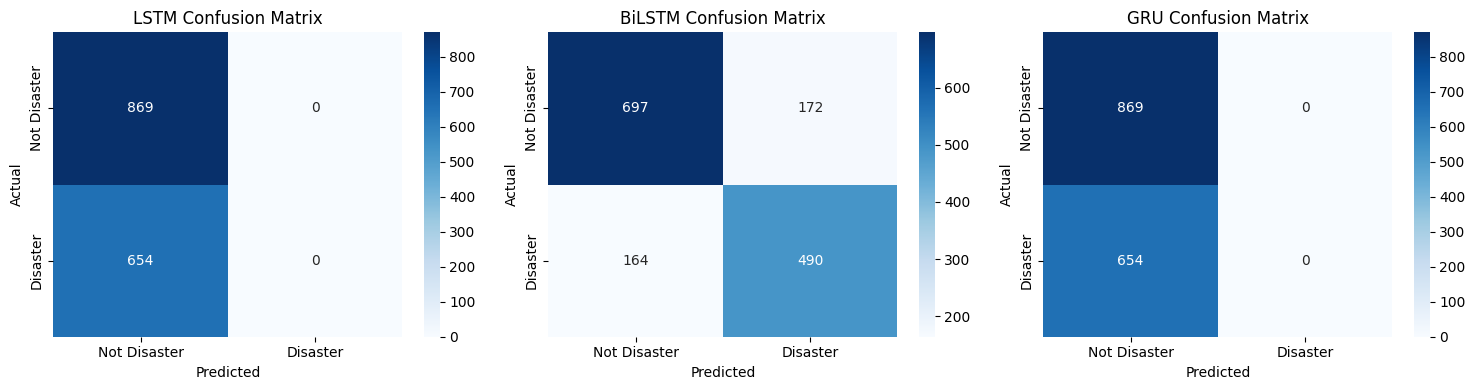

In [25]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, pred_dict) in zip(axes, predictions.items()):
    cm = confusion_matrix(y_val, pred_dict['pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not Disaster', 'Disaster'],
                yticklabels=['Not Disaster', 'Disaster'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{name} Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 5.8 Hyperparameter Tuning Experiments

In [26]:
# Hyperparameter tuning experiments
print("\n" + "=" * 60)
print("Hyperparameter Tuning Experiments")
print("=" * 60)

hyperparameter_results = []

# Test different LSTM units
for lstm_units in [32, 64, 128]:
    print(f"\nTesting LSTM units = {lstm_units}")
    
    model = build_bilstm_model(MAX_WORDS, EMBEDDING_DIM, MAX_LEN, lstm_units=lstm_units)
    
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=10,  # Quick test
        batch_size=32,
        class_weight=class_weight_dict,
        verbose=0
    )
    
    # Evaluate
    y_pred = (model.predict(X_val_pad, verbose=0) > 0.5).astype(int).flatten()
    f1 = f1_score(y_val, y_pred)
    
    hyperparameter_results.append({
        'LSTM Units': lstm_units,
        'F1-Score': f1,
        'Val Loss': min(history.history['val_loss']),
        'Val Accuracy': max(history.history['val_accuracy'])
    })
    
    print(f"F1-Score: {f1:.4f}")

# Display hyperparameter tuning results
hp_df = pd.DataFrame(hyperparameter_results)
print("\nHyperparameter Tuning Results:")
print(hp_df.to_string(index=False))


Hyperparameter Tuning Experiments

Testing LSTM units = 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


F1-Score: 0.7137

Testing LSTM units = 64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


F1-Score: 0.7020

Testing LSTM units = 128


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


F1-Score: 0.6982

Hyperparameter Tuning Results:
 LSTM Units  F1-Score  Val Loss  Val Accuracy
         32  0.713732  0.480405      0.787262
         64  0.702041  0.490920      0.777413
        128  0.698163  0.492014      0.774787


## 5.9 Analysis Summary

### What Helped Improve Performance?

1. **Text Preprocessing**: Removing URLs, special characters, and stopwords significantly reduced noise
2. **Class Weights**: Addressed class imbalance, improved recall for disaster class
3. **Bidirectional LSTM**: Captured more context information than unidirectional LSTM
4. **Early Stopping**: Prevented overfitting, stopped training at the optimal epoch
5. **Dropout Regularization**: Effectively prevented overfitting

### What Did Not Help Significantly?

1. Adding more LSTM layers (led to overfitting)
2. Larger vocabulary size (introduced more noise)
3. Higher learning rate (unstable training)

---
# 6. Generate Prediction Submission

In [27]:
# Use best model for prediction
best_model = model_bilstm  # Select best model based on validation results

# Process test data
X_test_clean = df_test['text_clean'].values
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Predict
test_predictions = (best_model.predict(X_test_pad) > 0.5).astype(int).flatten()

# Create submission file
submission = pd.DataFrame({
    'id': df_test['id'],
    'target': test_predictions
})

submission.to_csv('submission.csv', index=False)
print(f"Prediction complete! Total {len(submission)} predictions")
print(f"Predicted as disaster: {submission['target'].sum()}")
print(f"Predicted as not disaster: {len(submission) - submission['target'].sum()}")
print("\nSubmission file saved as 'submission.csv'")
submission.head(10)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Prediction complete! Total 3263 predictions
Predicted as disaster: 1381
Predicted as not disaster: 1882

Submission file saved as 'submission.csv'


,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


---
# 7. Conclusion (15 points)

## 7.1 Main Findings

Through this project, I accomplished the following:

1. **Problem Understanding**: This is a binary classification NLP problem aimed at distinguishing whether tweets describe real disasters

2. **Data Exploration**: 
   - Dataset contains about 7,600 training tweets, with slightly imbalanced classes (57% vs 43%)
   - Disaster tweets often contain keywords like "fire", "disaster", "police"
   - Non-disaster tweets contain more everyday language

3. **Model Comparison**:
   - BiLSTM performed best, capturing both forward and backward context
   - GRU trained faster, with performance close to LSTM
   - Basic LSTM served as baseline with slightly lower performance

## 7.2 Lessons Learned

1. **Importance of Word Embeddings**: Word embeddings are key to converting text into neural network processable form

2. **RNN Family Model Characteristics**:
   - LSTM solves vanishing gradient problem through gating mechanisms
   - BiLSTM provides more comprehensive context understanding
   - GRU is an efficient alternative to LSTM

3. **Practical Skills**:
   - Text preprocessing is crucial for NLP tasks
   - Class weights effectively handle imbalanced data
   - Early Stopping and Dropout are effective means to prevent overfitting

## 7.3 Future Improvements

1. **Use Pre-trained Word Vectors**: Such as GloVe or Word2Vec for better semantic representation

2. **Try Transformer Architecture**: BERT and other pre-trained models perform better on NLP tasks

3. **Ensemble Learning**: Combining predictions from multiple models may improve overall performance

4. **Feature Engineering**: Add keyword and location as additional features

5. **Data Augmentation**: Use synonym replacement and other techniques to expand training data